# 1 - Introdução

O seu projeto de predição de ataque cardíaco tem como objetivo utilizar técnicas de machine learning para criar um modelo capaz de identificar indivíduos com maior risco de desenvolver um ataque cardíaco. Esse tipo de modelo é extremamente importante, já que o ataque cardíaco é uma das principais causas de morte no mundo e a prevenção é fundamental para a saúde pública.

Para desenvolver esse modelo, você irá utilizar um conjunto de dados com informações sobre diversos fatores de risco para o desenvolvimento de um ataque cardíaco, tais como idade, gênero, histórico familiar, tabagismo, hipertensão, diabetes, colesterol, entre outros. Com base nessas informações, o modelo será treinado para aprender padrões e características que estejam associados a um maior risco de ataque cardíaco, permitindo que ele faça predições precisas sobre a probabilidade de um indivíduo sofrer um ataque cardíaco em um determinado período de tempo.

O desenvolvimento desse tipo de modelo tem grande potencial de impacto na área da saúde, uma vez que a identificação precoce de indivíduos com maior risco de desenvolver um ataque cardíaco pode levar a uma intervenção mais rápida e efetiva, reduzindo o número de mortes e melhorando a qualidade de vida da população em geral.

## 1.1 - Primeiras impressões

In [1]:
# Importando módulos necessários
import pandas as pd
from pandas_profiling import ProfileReport

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier

import pickle


%matplotlib inline

/tmp/ipykernel_25885/3810062527.py:3: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


In [2]:
# Lendo nosso dataset
dataset = pd.read_csv('/home/jdspy/Documentos/datasets/heart.csv')

# Visualizando informações iniciais
dataset.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [3]:
print('Nosso dataset tem dimensão:', dataset.shape)
print('O total de valores faltantes é', dataset.isnull().sum().sum())

Nosso dataset tem dimensão: (303, 14)
O total de valores faltantes é 0


In [4]:
# Cada coluna
dataset.columns

Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')

## 1.2 - Primeiros Tratamentos

In [5]:
# Renomeando coluna
new_columns = [
    'idade',
    'sexo',
    'dor_no_peito',
    'pressão_arterial_em_repouso',
    'colesterol_sérico',
    'acuçar_acima_de_120mg',
    'resultados_eletrocardiográficos',
    'frequencia_cardiaca_maxima',
    'angina_induzida',
    'depressão_de_st',
    'st',
    'numero_de_vasos',
    'thal',
    'alvo'
]

dataset.columns = new_columns

In [6]:
# Visualizando 10 observações aleatórias no dataset
dataset.sample(10)

,idade,sexo,dor_no_peito,pressão_arterial_em_repouso,colesterol_sérico,acuçar_acima_de_120mg,resultados_eletrocardiográficos,frequencia_cardiaca_maxima,angina_induzida,depressão_de_st,st,numero_de_vasos,thal,alvo
247,66,1,1,160,246,0,1,120,1,0.0,1,3,1,0
235,51,1,0,140,299,0,1,173,1,1.6,2,0,3,0
117,56,1,3,120,193,0,0,162,0,1.9,1,0,3,1
61,54,1,1,108,309,0,1,156,0,0.0,2,0,3,1
89,58,0,0,100,248,0,0,122,0,1.0,1,0,2,1
60,71,0,2,110,265,1,0,130,0,0.0,2,1,2,1
161,55,0,1,132,342,0,1,166,0,1.2,2,0,2,1
184,50,1,0,150,243,0,0,128,0,2.6,1,0,3,0
200,44,1,0,110,197,0,0,177,0,0.0,2,1,2,0
174,60,1,0,130,206,0,0,132,1,2.4,1,2,3,0


**Sobre cada Variável**

    idade
    sexo
    tipo de dor no peito (4 valores)
    pressão arterial em repouso
    colesterol sérico em mg/dl
    açúcar no sangue em jejum > 120 mg/dl
    resultados eletrocardiográficos em repouso (valores 0,1,2)
    frequência cardíaca máxima alcançada
    angina induzida por exercício
    depressão de ST induzida por exercício em relação ao repouso
    a inclinação do segmento ST de pico de exercício
    número de principais vasos (0-3) coloridos por fluoroscopia
    thal: 0 = normal; 1 = defeito fixo; 2 = defeito reversível
    alvo: 0 = menor chance de ataque cardíaco, 1 = maior chance de ataque cardíaco.

# 2 - Análise Exploratória de Dados (EDA)

## 2.1 - Relatório com Pandas Profiling

In [7]:
# profile = ProfileReport(dataset)

# profile.to_file('profile.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## 2.2 - Estatística Aplicada

In [8]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   idade                            303 non-null    int64  
 1   sexo                             303 non-null    int64  
 2   dor_no_peito                     303 non-null    int64  
 3   pressão_arterial_em_repouso      303 non-null    int64  
 4   colesterol_sérico                303 non-null    int64  
 5   acuçar_acima_de_120mg            303 non-null    int64  
 6   resultados_eletrocardiográficos  303 non-null    int64  
 7   frequencia_cardiaca_maxima       303 non-null    int64  
 8   angina_induzida                  303 non-null    int64  
 9   depressão_de_st                  303 non-null    float64
 10  st                               303 non-null    int64  
 11  numero_de_vasos                  303 non-null    int64  
 12  thal                  

In [9]:
dataset.describe()

,idade,sexo,dor_no_peito,pressão_arterial_em_repouso,colesterol_sérico,acuçar_acima_de_120mg,resultados_eletrocardiográficos,frequencia_cardiaca_maxima,angina_induzida,depressão_de_st,st,numero_de_vasos,thal,alvo
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


In [10]:
dataset.skew()

idade                             -0.202463
sexo                              -0.791335
dor_no_peito                       0.484732
pressão_arterial_em_repouso        0.713768
colesterol_sérico                  1.143401
acuçar_acima_de_120mg              1.986652
resultados_eletrocardiográficos    0.162522
frequencia_cardiaca_maxima        -0.537410
angina_induzida                    0.742532
depressão_de_st                    1.269720
st                                -0.508316
numero_de_vasos                    1.310422
thal                              -0.476722
alvo                              -0.179821
dtype: float64

In [11]:
dataset['alvo'].value_counts()

1    165
0    138
Name: alvo, dtype: int64

<AxesSubplot:xlabel='idade', ylabel='Count'>

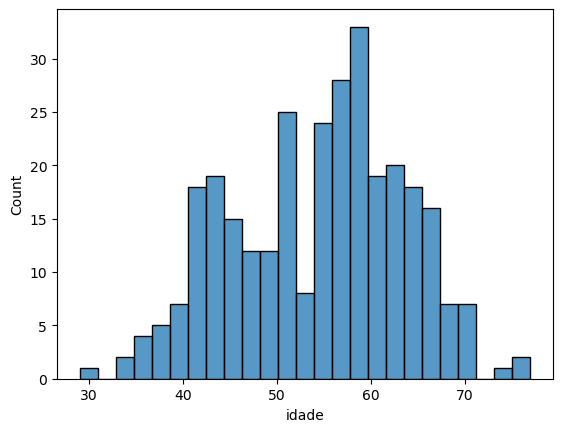

In [12]:
sns.histplot(dataset['idade'], bins=25)

<AxesSubplot:>

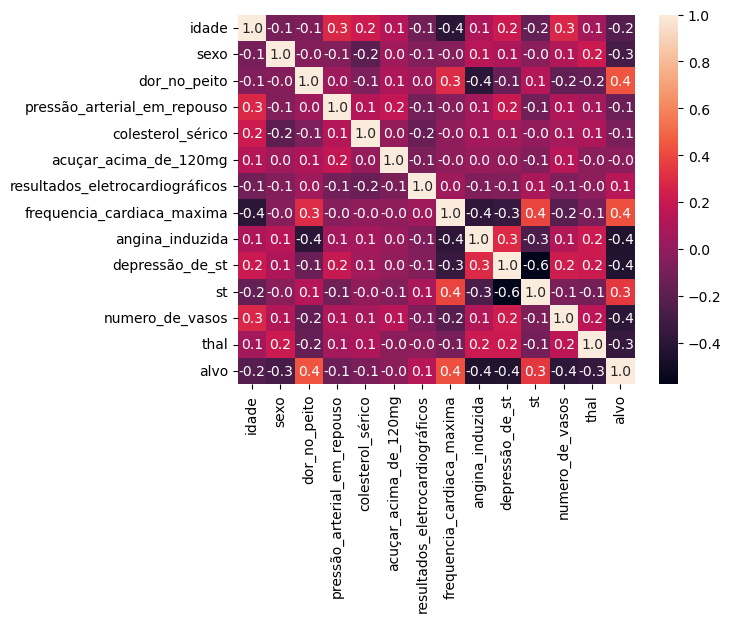

In [13]:
sns.heatmap(dataset.corr(), annot=True, fmt='.1f')

# 3 - Modelagem dos Dados

## 3.1 - Definindo o modelo base 

In [14]:
x = dataset.drop(['alvo'], axis=1)
y = dataset['alvo']

In [15]:
x_train, x_test, y_train, y_test = train_test_split(x, y)

In [16]:
dummy_classifier = DummyClassifier()

dummy_classifier.fit(x_train, y_train)

print('A acurácia base de um modelo dummy é de: %.2f' % dummy_classifier.score(x_test, y_test))

A acurácia base de um modelo dummy é de: 0.51


## 3.2 - Modelando uma árvore de decisão

In [17]:
decision_tree_classifier = DecisionTreeClassifier()
kfold = KFold(n_splits=100, shuffle=True, random_state=256)

In [18]:
cross_validation = cross_validate(decision_tree_classifier, x, y, cv = kfold, scoring='accuracy')

print('A acurácia média do modelo é de %.2f' % cross_validation['test_score'].mean())

A acurácia média do modelo é de 0.79


## 3.3 - Seleção de Variáveis

In [19]:
decision_tree_classifier.fit(x, y)

DecisionTreeClassifier()

In [20]:
decision_tree_classifier.feature_importances_

array([0.05918792, 0.02245064, 0.26627111, 0.0637111 , 0.12007267,
       0.        , 0.01862978, 0.05774279, 0.02042739, 0.09310002,
       0.02620208, 0.13947727, 0.11272723])

In [21]:
decision_tree_classifier.feature_names_in_

array(['idade', 'sexo', 'dor_no_peito', 'pressão_arterial_em_repouso',
       'colesterol_sérico', 'acuçar_acima_de_120mg',
       'resultados_eletrocardiográficos', 'frequencia_cardiaca_maxima',
       'angina_induzida', 'depressão_de_st', 'st', 'numero_de_vasos',
       'thal'], dtype=object)

In [22]:
scores = pd.Series()

for i, feature_name in enumerate(decision_tree_classifier.feature_names_in_):
    scores[feature_name] = decision_tree_classifier.feature_importances_[i]

/tmp/ipykernel_25885/3978828264.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  scores = pd.Series()


In [23]:
scores.sort_values(ascending=False)

dor_no_peito                       0.266271
numero_de_vasos                    0.139477
colesterol_sérico                  0.120073
thal                               0.112727
depressão_de_st                    0.093100
pressão_arterial_em_repouso        0.063711
idade                              0.059188
frequencia_cardiaca_maxima         0.057743
st                                 0.026202
sexo                               0.022451
angina_induzida                    0.020427
resultados_eletrocardiográficos    0.018630
acuçar_acima_de_120mg              0.000000
dtype: float64

In [24]:
x = x[scores.sort_values(ascending=False)[:5].index]

In [25]:
decision_tree_classifier = DecisionTreeClassifier()
kfold = KFold(n_splits=5, shuffle=True, random_state=256)

cross_validation = cross_validate(decision_tree_classifier, x, y, cv = kfold, scoring='accuracy')

print('A acurácia média do modelo é de %.2f' % cross_validation['test_score'].mean())

A acurácia média do modelo é de 0.75


## 3.4 - Seleção de Parâmetros

In [26]:
scores = pd.Series()
for i in range(1, 100, 1):
    decision_tree_classifier = DecisionTreeClassifier(max_depth=i)
    cross_validation = cross_validate(decision_tree_classifier, x, y, cv = kfold, scoring='accuracy')
    
    scores['max_depth=' + str(i)] = cross_validation['test_score'].mean()

/tmp/ipykernel_25885/4199832160.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  scores = pd.Series()


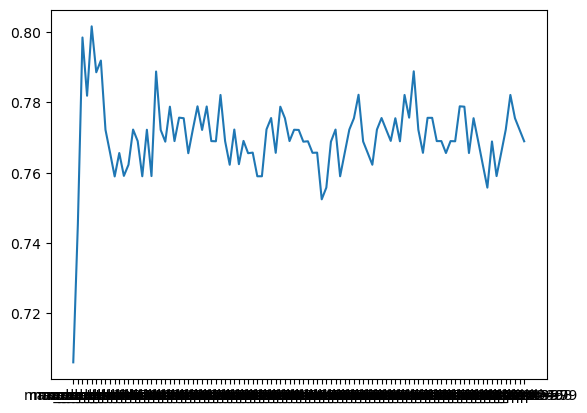

In [27]:
plt.plot(scores)

In [28]:
scores.sort_values(ascending=False)

max_depth=5     0.801585
max_depth=3     0.798415
max_depth=7     0.791858
max_depth=75    0.788798
max_depth=19    0.788743
                  ...   
max_depth=56    0.755738
max_depth=91    0.755738
max_depth=55    0.752404
max_depth=2     0.745410
max_depth=1     0.706066
Length: 99, dtype: float64

In [29]:
params = {'max_depth': list(range(1, 100, 1))}

In [37]:
decision_tree_classifier = DecisionTreeClassifier()

decision_tree_classifier.fit(x, y)

grid_search = GridSearchCV(decision_tree_classifier, param_grid=params, scoring='accuracy', cv=5)

In [38]:
grid_search.fit(x, y)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                       23, 24, 25, 26, 27, 28, 29, 30, ...]},
             scoring='accuracy')

In [39]:
grid_search.best_params_

{'max_depth': 3}

In [40]:
grid_search.best_score_

0.8083606557377049

## 4 - Salvando modelo

In [34]:
x.columns

Index(['dor_no_peito', 'numero_de_vasos', 'colesterol_sérico', 'thal',
       'depressão_de_st'],
      dtype='object')

In [35]:
decision_tree_classifier = DecisionTreeClassifier(max_depth=4)
decision_tree_classifier.fit(x, y)

DecisionTreeClassifier(max_depth=4)

In [36]:
with open('model.sav', 'wb') as f:
    pickle.dump(decision_tree_classifier, f)